In [1]:
import pandas as pd
import numpy as np
#defining the class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#importing the data
train = pd.read_csv("D:/data/train.csv")
test = pd.read_csv('D:/data/test.csv')

In [2]:
#checking for missing values:
print("checking for missing values in train data")
print(train.isnull().sum())

print("checking for missing data in test data")
print(test.isnull().sum())

checking for missing values in train data
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
checking for missing data in test data
id              0
comment_text    0
dtype: int64


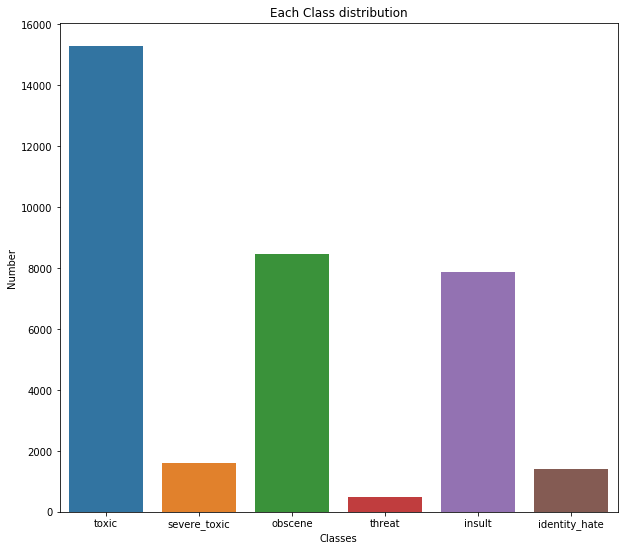

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Visualization of train data 

classes=train.iloc[:,2:].sum() # taking the count of classes from toxic to identity hate 
plt.figure(figsize=(10,9))
sns.barplot(classes.index, classes.values)
plt.title("Each Class distribution")
plt.ylabel('Number')
plt.xlabel('Classes')
plt.show()

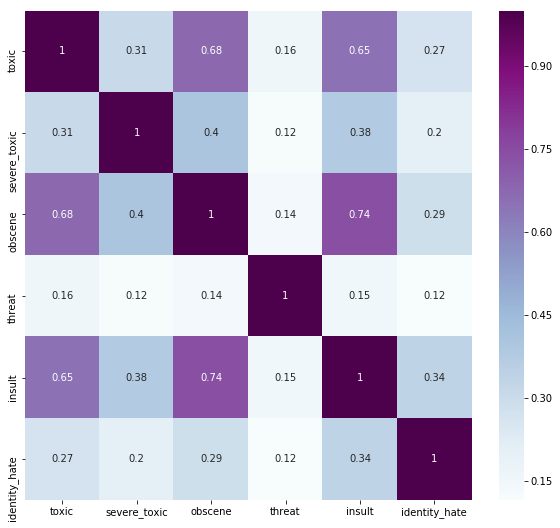

In [4]:
#displaying coorelation matrix
corr = train.iloc[:,2:].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr,xticklabels = corr.columns,yticklabels=corr.columns,annot= True,cmap="BuPu")

plt.show()

In [5]:
#determing output y values
test_y = train[class_names].values

#splitting into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train, test_y, test_size = 0.1)


In [7]:
import keras
from keras.preprocessing.text import Tokenizer


# data cleaning

#covert the text into lower case
X_train_lower = X_train["comment_text"].str.lower()
X_test_lower = X_test["comment_text"].str.lower()
test_lower = test["comment_text"].str.lower()

# remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
X_train_lower = X_train_lower.apply(clean_stopwords)

#tokenizing 
max_features = 50000
tokenizer = Tokenizer(num_words = max_features,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True,)
tokenizer.fit_on_texts(X_train_lower)
X_train["comment_seq"] = tokenizer.texts_to_sequences(X_train_lower)
X_test["comment_seq"] = tokenizer.texts_to_sequences(X_test_lower)
test["comment_seq"] = tokenizer.texts_to_sequences(test_lower)




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kpgaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\kpgaj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kpgaj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#converting sequences (lists of integers) into a 2D Numpy array
maxlen=100
X_train=keras.preprocessing.sequence.pad_sequences(X_train.comment_seq, maxlen=maxlen, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_test=keras.preprocessing.sequence.pad_sequences(X_test.comment_seq, maxlen=maxlen, dtype='int32', padding='pre', truncating='pre', value=0.0)
test = keras.preprocessing.sequence.pad_sequences(test.comment_seq, maxlen=maxlen, dtype='int32', padding='pre', truncating='pre', value=0.0)


In [9]:
# embedding GloVe  (instead of W2v we are using GloVe(Global Vectors for Word Representation))
embedding_location = "D:/data/crawl-300d-2M.vec"

def get_coefficients(word,*arr): 
      return word, np.asarray(arr, dtype='float32')

embed_index = dict(get_coefficients(*o.strip().split(" ")) for o in open(embedding_location,errors= 'ignore'))


word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embed_size = 300

embed_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embed_vector = embed_index.get(word)
    if embed_vector is not None: 
        embed_matrix[i] = embed_vector

In [46]:
from keras.models import Model,load_model
from keras.optimizers import RMSprop
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding ,SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPooling1D, MaxPooling1D,GRU,concatenate,GlobalAveragePooling1D
from keras.models import Sequential

inp = Input(shape = (maxlen,))
#adding embedding layer
outputs = Embedding(max_features, embed_size, weights = [embed_matrix], trainable = False)(inp)

#adding dropout layer
outputs = SpatialDropout1D(0.2)(outputs)

# adding Recurrent layer


outputs = Bidirectional(GRU(128, return_sequences = True))(outputs)
# #adding convolution layer

outputs = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(outputs)


# Concatination of maxpool and average max pool layers

outputs = concatenate([GlobalMaxPooling1D()(outputs),GlobalAveragePooling1D()(outputs)])

# Add fully connected layers
outputs = Dense(128, activation='relu')(outputs)

outputs = Dropout(0.1)(outputs)
outputs = Dense(64, activation="relu")(outputs)
outputs = Dropout(0.1)(outputs)
outputs = Dense(6, activation="sigmoid")(outputs)



model = Model(inputs = inp,outputs = outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 100, 300)     15000000    input_21[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_15 (SpatialDr (None, 100, 300)     0           embedding_22[0][0]               
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 100, 256)     329472      spatial_dropout1d_15[0][0]       
__________________________________________________________________________________________________
conv1d_9 (

In [58]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model,load_model
epoch = 2
batch_size = 64

# with a constant learning rate 

MM=model.fit(X_train,Y_train,batch_size=batch_size, epochs=epoch, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], validation_split=0.1)


Train on 129251 samples, validate on 14362 samples
Epoch 1/2
129251/129251 [==============================] - 3923s 30ms/step - loss: 0.0533 - acc: 0.9807 - val_loss: 0.0467 - val_acc: 0.9824
Epoch 2/2
129251/129251 [==============================] - 3907s 30ms/step - loss: 0.0463 - acc: 0.9824 - val_loss: 0.0467 - val_acc: 0.9822


In [59]:
# predicting on test 
pred = model.predict(test, batch_size = 10, verbose = 1)

153164/153164 [==============================] - 5710s 37ms/step


In [61]:
#finding the accuracy of the model

accruracy = model.evaluate(X_test,Y_test)
print('Test data \n  Loss: {}\n  Accuracy: {}'.format(accruracy[0],accruracy[1]))

15958/15958 [==============================] - 32s 2ms/step
Test data 
  Loss: 0.05164828983970432
  Accuracy: 0.9801875637174923


Train on 129251 samples, validate on 14362 samples
Epoch 1/2
  1088/129251 [..............................] - ETA: 59:44 - loss: 0.0479 - acc: 0.9810

KeyboardInterrupt: 

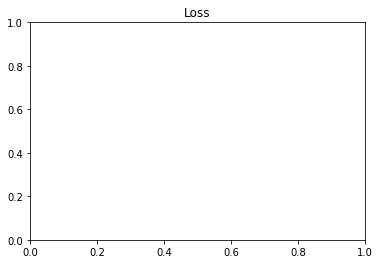

In [62]:
#Loss and Accuracy curves
plt.title('Loss')
plt.plot(MM.MM['loss'], label='train')
plt.plot(MM.MM['val_loss'], label='test')
plt.legend()
plt.show();